## Image segmentation with CamVid

In [0]:
from google.colab import drive #mount drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%reload_ext autoreload #save outputs
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import * # import libraries
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
path = untar_data(URLs.CAMVID) #extract data
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [0]:
path_lbl = path/'labels' #make paths
path_img = path/'images'

## Subset classes

In [0]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [0]:
fnames = get_image_files(path_img) #verify the image's paths are correctly loaded
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_05010.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_01740.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f03300.png')]

In [0]:
lbl_names = get_image_files(path_lbl) #do the same for labels
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_06480_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08340_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_05760_P.png')]

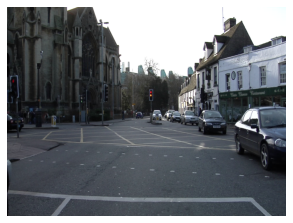

In [0]:
img_f = fnames[0] #see an example image
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}' #stem plot, remove -P suffix --> mask function

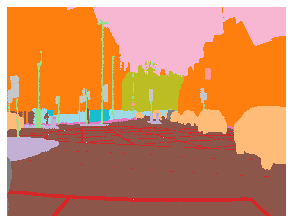

In [0]:
mask = open_mask(get_y_fn(img_f)) #show that image with a mask
mask.show(figsize=(5,5), alpha=1)

In [0]:
src_size = np.array(mask.shape[1:]) #print the array of pixel values
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [22, 22, 22,  ..., 17, 17, 17],
          [22, 22, 22,  ..., 17, 17, 17],
          [22, 22, 22,  ..., 17, 17, 17]]]))

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes #labels

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [0]:
size = src_size//2

free = gpu_mem_get_free_no_cache() #choose batch size depending on gpu memory
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16270MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img) #split train and validation sets, add labels
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True) #this is our dataset, normalized
        .databunch(bs=bs)
        .normalize(imagenet_stats))

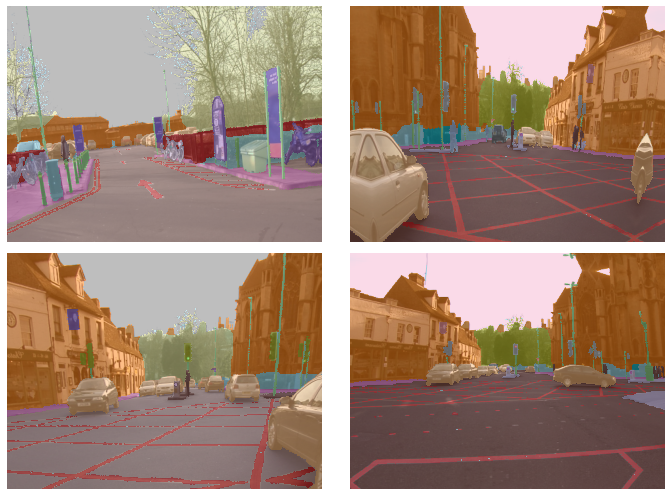

In [0]:
data.show_batch(2, figsize=(10,7)) #let's see a few examples

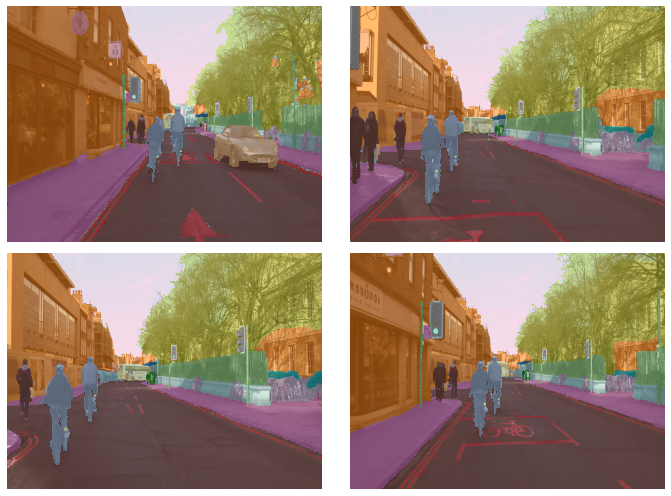

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid) #let's see a few examples from the validation set

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)} #function to put the Void label on an image
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean() #see the mean 

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd) #dl our learner

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


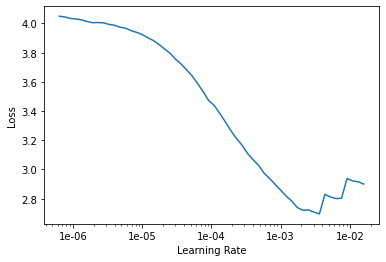

In [0]:
lr_find(learn) #train
learn.recorder.plot()

In [0]:
lr=3e-3 #slice

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9) #train again after finetuning

epoch,train_loss,valid_loss,acc_camvid,time
0,1.248586,0.834058,0.799967,01:00
1,0.911540,0.705482,0.819601,00:56
2,0.738343,0.575897,0.848189,00:56
3,0.664493,0.510978,0.861563,00:57
4,0.621503,0.473454,0.874602,00:57
5,2.038994,2.024055,0.478110,00:58
6,1.531637,1.259300,0.608236,00:58
7,1.100273,0.798557,0.796547,00:58
8,0.798894,0.564699,0.852779,00:59
9,0.623887,0.488405,0.866375,00:57


In [0]:
learn.save('stage-1') #save the model

In [0]:
learn.load('stage-1'); #load it

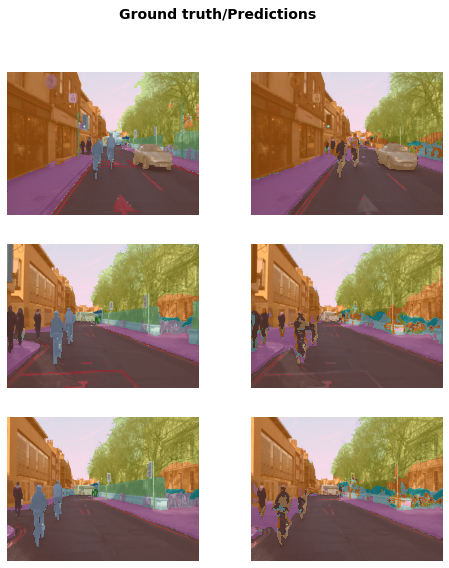

In [0]:
learn.show_results(rows=3, figsize=(8,9)) #see a few results

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4) #new slice

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8) #train again after finetuning

epoch,train_loss,valid_loss,acc_camvid,time
0,0.542362,0.472076,0.870199,00:57
1,0.529229,0.462539,0.869907,00:58
2,0.518212,0.449434,0.873826,00:58
3,0.495081,0.413058,0.884880,00:58
4,0.462281,0.373707,0.891548,00:58
5,0.440023,0.381396,0.894796,00:58
6,0.421857,0.340769,0.910138,00:57
7,0.394885,0.328408,0.909611,00:58
8,0.379101,0.316771,0.913253,00:57
9,0.363875,0.309078,0.915142,00:58


In [0]:
learn.save('stage-2'); #results are better, let's save this

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
learn.destroy() #forget about the learner

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 15559MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True) #load our dataset again
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd) #load the learner

In [0]:
learn.load('stage-2'); #what we trained before that worked well

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


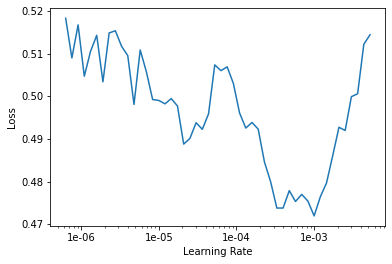

In [0]:
lr_find(learn) #find the learning rate
learn.recorder.plot()

In [0]:
lr=1e-3 #slice

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8) #train

epoch,train_loss,valid_loss,acc_camvid,time
0,0.437372,0.345135,0.902009,03:37
1,0.409293,0.307939,0.913581,03:34
2,0.387344,0.320825,0.912287,03:34
3,0.381690,0.273695,0.928879,03:34
4,0.358135,0.286970,0.924371,03:34
5,0.383042,0.322325,0.911980,03:34
6,0.376408,0.285982,0.921791,03:34
7,0.343673,0.292736,0.914673,03:34
8,0.306341,0.281830,0.922241,03:34
9,0.266964,0.249128,0.931647,03:34


In [0]:
learn.save('stage-1-big') #saving it

In [0]:
learn.load('stage-1-big'); #loading it

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10) #new slice

In [0]:
learn.fit_one_cycle(10, lrs) #training on that 

epoch,train_loss,valid_loss,acc_camvid,time
0,0.257786,0.253681,0.930455,03:41
1,0.250978,0.237999,0.933769,03:41
2,0.242890,0.247998,0.933040,03:41
3,0.233391,0.248693,0.932394,03:41
4,0.230914,0.242088,0.934192,03:41
5,0.223411,0.245930,0.933762,03:40
6,0.230082,0.244595,0.933167,03:41
7,0.213226,0.242642,0.934044,03:41
8,0.218660,0.237800,0.935424,03:41
9,0.217232,0.237528,0.935162,03:41


In [0]:
learn.save('stage-2-big') #save it 

In [0]:
learn.load('stage-2-big'); #load it

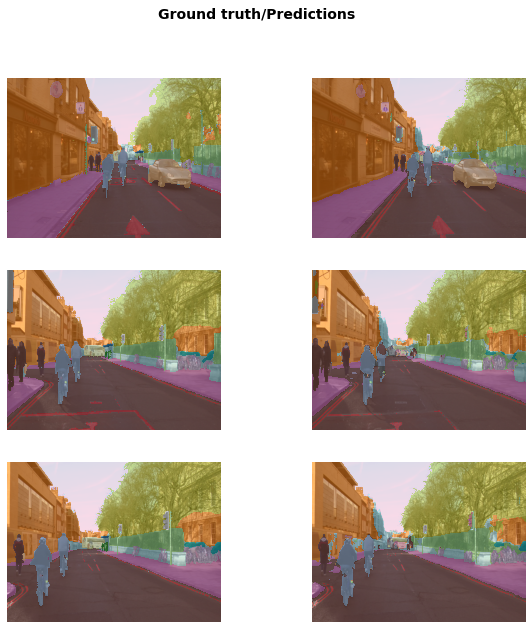

In [0]:
learn.show_results(rows=3, figsize=(10,10)) #let's see a few results

## fin